# 第8章 日本語 WaveNet 音声合成システムの実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/r9y9/ttslearn/blob/master/notebooks/ch08_Recipe-WaveNet.ipynb)

Google colabでの実行における推定所要時間: 5時間

このノートブックに記載のレシピの設定は、Google Colab上で実行した場合のタイムアウトを避けるため、学習条件を書籍に記載の設定から一部修正していることに注意してください (バッチサイズを減らす等)。
参考までに、書籍に記載の条件で、著者 (山本) がレシピを実行した結果を以下で公開しています。

- Tensorboard logs: https://tensorboard.dev/experiment/yXyg9qgfQRSGxvil5FA4xw/
- expディレクトリ(学習済みモデル、合成音声を含む) : https://drive.google.com/file/d/1Z09yCCAKyKOUU3Zsdxs0mZ1Q-TCPqFHA/view?usp=sharing (135.2 MB)

## 準備

### Google Colabを利用する場合

Google Colab上でこのノートブックを実行する場合は、メニューの「ランタイム -> ランタイムのタイムの変更」から、「ハードウェア アクセラレータ」を **GPU** に変更してください。

### Python version

In [1]:
!python -VV

Python 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]


### ttslearn のインストール

In [2]:
%%capture
try:
    import ttslearn
except ImportError:
    !pip install ttslearn

In [3]:
import ttslearn
ttslearn.__version__

'0.2.2'

## 8.1 本章の日本語音声合成システムの実装

### 学習済みモデルを用いた音声合成

In [4]:
from ttslearn.wavenet import WaveNetTTS
from tqdm.notebook import tqdm
from IPython.display import Audio

engine = WaveNetTTS()
wav, sr = engine.tts("ウェーブネットにチャレンジしましょう！", tqdm=tqdm)
Audio(wav, rate=sr)

  0%|          | 0/37440 [00:00<?, ?it/s]

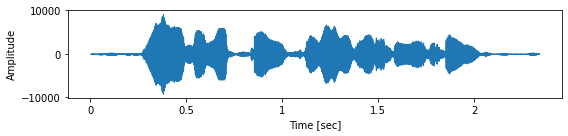

In [5]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 2))
librosa.display.waveshow(wav.astype(np.float32), sr=sr, ax=ax)
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Amplitude")
plt.tight_layout()

### レシピ実行の前準備

In [6]:
%%capture
from ttslearn.env import is_colab
from os.path import exists

# pip install ttslearn ではレシピはインストールされないので、手動でダウンロード
if is_colab() and not exists("recipes.zip"):
    !curl -LO https://github.com/r9y9/ttslearn/releases/download/v{ttslearn.__version__}/recipes.zip
    !unzip -o recipes.zip

In [7]:
import os
# recipeのディレクトリに移動
cwd = os.getcwd()
if cwd.endswith("notebooks"):
    os.chdir("../recipes/wavenet/")
elif is_colab():
    os.chdir("recipes/wavenet/")

In [8]:
import time
start_time = time.time()

### パッケージのインポート

In [9]:
%pylab inline
%load_ext autoreload
%load_ext tensorboard
%autoreload
import IPython
from IPython.display import Audio
import tensorboard as tb
import os

Populating the interactive namespace from numpy and matplotlib


In [10]:
# 数値演算
import numpy as np
import torch
from torch import nn
# 音声波形の読み込み
from scipy.io import wavfile
# フルコンテキストラベル、質問ファイルの読み込み
from nnmnkwii.io import hts
# 音声分析
import pyworld
# 音声分析、可視化
import librosa
import librosa.display
import pandas as pd
# Pythonで学ぶ音声合成
import ttslearn

In [11]:
# シードの固定
from ttslearn.util import init_seed
init_seed(773)

In [12]:
torch.__version__

'1.10.0'

### 描画周りの設定

In [13]:
from ttslearn.notebook import get_cmap, init_plot_style, savefig
cmap = get_cmap()
init_plot_style()

### レシピの設定

In [14]:
# run.shを利用した学習スクリプトをnotebookから行いたい場合は、True
# google colab の場合は、True とします
# ローカル環境の場合、run.sh をターミナルから実行することを推奨します。
# その場合、このノートブックは可視化・学習済みモデルのテストのために利用します。
run_sh = is_colab()

# 注意: WaveNetを利用した評価データに対する音声生成は時間がかかることに注意
run_stage8 = True

# run.sh経由で実行するスクリプトのtqdm
run_sh_tqdm = "none"

# CUDA
# NOTE: run.shの引数として渡すので、boolではなく文字列で定義しています
cudnn_benchmark = "true"
cudnn_deterministic = "false"

# 特徴抽出時の並列処理のジョブ数
n_jobs = os.cpu_count()//2

# 継続長モデルの設定ファイル名
duration_config_name="duration_rnn"
# 音響モデルの設定ファイル名
logf0_config_name="logf0_rnn"
# WaveNetの設定ファイル名
wavenet_config_name="wavenet_sr16k_mulaw256"

# 継続長モデル & 対数F0予測モデルの学習におけるバッチサイズ
dnntts_batch_size = 32
# 継続長モデル & 対数F0予測モデルの学習におけるエポック数
# 注意: 計算時間を少なくするために、少なく設定しています。品質を向上させるためには、30 ~ 50 のエポック数を試してみてください。
dnntts_nepochs = 5

# WaveNet学習におけるバッチサイズ
# 推奨バッチサイズ: 8以上
# 動作確認のため、小さな値に設定しています
wavenet_batch_size = 4
# WavaNetの学習イテレーション数
# 注意: 十分な品質を得るために必要な値: 300k ~ 500k steps
wavenet_max_train_steps = 50000

# 音声生成を行う発話数
# WaveNetの推論は時間がかかるので、ノートブックで表示する5つのみ生成する
num_eval_utts = 5

# ノートブックで利用するテスト用の発話（学習データ、評価データ）
train_utt = "BASIC5000_0001"
test_utt = "BASIC5000_5000"

### Tensorboard によるログの可視化

In [15]:
# ノートブック上から tensorboard のログを確認する場合、次の行を有効にしてください
if is_colab():
    %tensorboard --logdir tensorboard/

## プログラム実装の前準備

### stage -1: コーパスのダウンロード

In [16]:
if is_colab():
    ! ./run.sh --stage -1 --stop-stage -1

### Stage 0: 学習/検証/評価データの分割

In [17]:
if run_sh:
    ! ./run.sh --stage 0 --stop-stage 0

In [18]:
! ls data/

dev.list  eval.list  train.list  utt_list.txt


In [19]:
! head data/dev.list

BASIC5000_4574
BASIC5000_4575
BASIC5000_4576
BASIC5000_4578
BASIC5000_4579
BASIC5000_4580
BASIC5000_4582
BASIC5000_4583
BASIC5000_4584
BASIC5000_4585


## 8.2 データの前処理

### 継続長モデルのための前処理

バッチ処理を行うコマンドラインプログラムは、 `recipes/dnntts/preprocess_duration.py` を参照してください。

In [20]:
if run_sh:
    ! ./run.sh --stage 1 --stop-stage 1 --n-jobs $n_jobs 

### 対数 F0 予測モデルのための前処理

#### 対数F0 + 有声/無声フラグの計算

In [21]:
from nnmnkwii.preprocessing import delta_features
from nnmnkwii.preprocessing.f0 import interp1d
from ttslearn.dsp import f0_to_lf0

def world_log_f0_vuv(x, sr):
    f0, timeaxis = pyworld.dio(x, sr)
    f0 = pyworld.stonemask(x, f0, timeaxis, sr)
    vuv = (f0 > 0).astype(np.float32)

    # 連続対数基本周波数
    lf0 = f0_to_lf0(f0)
    lf0 = interp1d(lf0)

    # 連続基本周波数と有声/無声フラグを2次元の行列の形にしておく
    lf0 = lf0[:, np.newaxis] if len(lf0.shape) == 1 else lf0
    vuv = vuv[:, np.newaxis] if len(vuv.shape) == 1 else vuv

    # 動的特徴量の計算
    windows = [
        [1.0],  # 静的特徴量に対する窓
        [-0.5, 0.0, 0.5],  # 1 次動的特徴量に対する窓
        [1.0, -2.0, 1.0],  # 2 次動的特徴量に対する窓
    ]
    lf0 = delta_features(lf0, windows)

    # すべての特徴量を結合
    feats = np.hstack([lf0, vuv]).astype(np.float32)

    return feats

#### 対数F0 + 有声/無声フラグの可視化

/home/vscode/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.


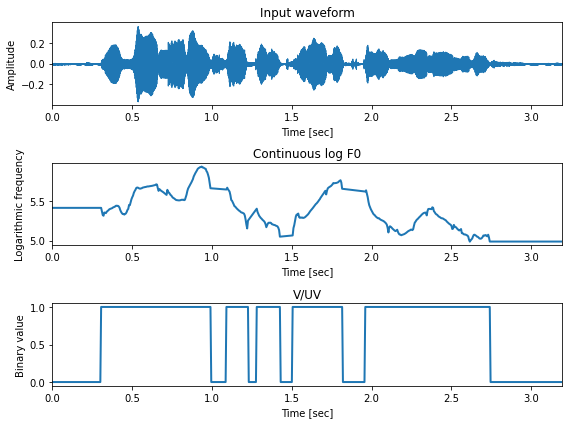

In [22]:
from ttslearn.dsp import lf0_to_f0

sr = 16000
_sr, x = wavfile.read(ttslearn.util.example_audio_file())
x = (x / 32768).astype(np.float64)
x = librosa.resample(x, orig_sr=_sr, target_sr=sr)

out_feats = world_log_f0_vuv(x, sr)
lf0 = out_feats[:, 0]
vuv = out_feats[:, -1]

timeaxis = librosa.frames_to_time(
    np.arange(len(lf0)), sr=sr, hop_length=int(0.005 * sr)
)

fig, ax = plt.subplots(3, 1, figsize=(8, 6))
ax[0].set_title("Input waveform")
ax[1].set_title("Continuous log F0")
ax[2].set_title("V/UV")

librosa.display.waveshow(x, sr=sr, x_axis="time", ax=ax[0])
ax[1].plot(timeaxis, lf0, linewidth=2)
ax[2].plot(timeaxis, vuv, linewidth=2)

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_xlim(0, len(x) / sr)
    a.set_xticks(np.arange(0, 3.5, 0.5))
    a.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))

ax[0].set_ylabel("Amplitude")
ax[1].set_ylabel("Logarithmic frequency")
ax[2].set_ylabel("Binary value")

plt.tight_layout()

#### 1発話に対する前処理

In [23]:
from nnmnkwii.frontend import merlin as fe

# HTS 形式の質問ファイルを読み込み
binary_dict, numeric_dict = hts.load_question_set(ttslearn.util.example_qst_file())

# フルコンテキストラベルの読み込み
labels = hts.load(ttslearn.util.example_label_file())

# フレーム単位の言語特徴量を抽出
in_feats = fe.linguistic_features(
    labels,
    binary_dict,
    numeric_dict,
    add_frame_features=True,
    subphone_features="coarse_coding",
)

# 音声ファイルの読み込み
sr = 16000
_sr, x = wavfile.read(ttslearn.util.example_audio_file())
x = (x / 32768).astype(np.float64)
x = librosa.resample(x, orig_sr=_sr,target_sr= sr)

# 連続対数基本周波数と有声/無声フラグを結合した特徴量の計算
out_feats = world_log_f0_vuv(x.astype(np.float64), sr)

# フレーム数の調整
minL = min(in_feats.shape[0], out_feats.shape[0])
in_feats, out_feats = in_feats[:minL], out_feats[:minL]

# 冒頭と末尾の非音声区間の長さを調整
assert "sil" in labels.contexts[0] and "sil" in labels.contexts[-1]
start_frame = int(labels.start_times[1] / 50000)
end_frame = int(labels.end_times[-2] / 50000)

# 冒頭：50 ミリ秒、末尾：100 ミリ秒
start_frame = max(0, start_frame - int(0.050 / 0.005))
end_frame = min(minL, end_frame + int(0.100 / 0.005))

in_feats = in_feats[start_frame:end_frame]
out_feats = out_feats[start_frame:end_frame]

In [24]:
print ("入力特徴量のサイズ:", in_feats.shape)
print ("出力特徴量のサイズ:", out_feats.shape)

入力特徴量のサイズ: (568, 329)
出力特徴量のサイズ: (568, 4)


出力はf0,f0',f0'',有声/無声フラグ(v/uv)

#### レシピの stage 2 の実行

上記の処理を行うバッチ処理のプログラムは、`preprocess_logf0.py` にあります。

In [25]:
if run_sh:
    ! ./run.sh --stage 2 --stop-stage 2 --n-jobs $n_jobs

### WaveNet のための前処理

#### 1発話に対する前処理

In [26]:
from ttslearn.dsp import mulaw_quantize
from ttslearn.dsp import world_log_f0_vuv

# HTS 形式の質問ファイルを読み込み
binary_dict, numeric_dict = hts.load_question_set(ttslearn.util.example_qst_file())

# フルコンテキストラベルの読み込み
labels = hts.load(ttslearn.util.example_label_file())

# フレーム単位の言語特徴量の抽出
in_feats = fe.linguistic_features(
    labels,
    binary_dict,
    numeric_dict,
    add_frame_features=True,
    subphone_features="coarse_coding",
)

# 音声ファイルの読み込み
sr = 16000
_sr, x = wavfile.read(ttslearn.util.example_audio_file())
x = (x / 32768).astype(np.float64)
x = librosa.resample(x, orig_sr=_sr, target_sr=sr)

# 連続対数基本周波数と有声/無声フラグを結合した特徴量の計算
log_f0_vuv = world_log_f0_vuv(x.astype(np.float64), sr)

# フレーム数の調整
minL = min(in_feats.shape[0], log_f0_vuv.shape[0])
in_feats, log_f0_vuv = in_feats[:minL], log_f0_vuv[:minL]

# 冒頭と末尾の非音声区間の長さを調整
assert "sil" in labels.contexts[0] and "sil" in labels.contexts[-1]
start_frame = int(labels.start_times[1] / 50000)
end_frame = int(labels.end_times[-2] / 50000)

# 冒頭：50 ミリ秒、末尾：100 ミリ秒
start_frame = max(0, start_frame - int(0.050 / 0.005))
end_frame = min(minL, end_frame + int(0.100 / 0.005))

in_feats = in_feats[start_frame:end_frame]
log_f0_vuv = log_f0_vuv[start_frame:end_frame]

# 言語特徴量と連続対数基本周波数を結合
in_feats = np.hstack([in_feats, log_f0_vuv])

# 時間領域で音声の長さを調整
x = x[int(start_frame * 0.005 * sr) :]
length = int(sr * 0.005) * in_feats.shape[0]
x = pad_1d(x, length) if len(x) < length else x[:length]

# mu-law 量子化
quantized_x = mulaw_quantize(x)

# 条件付け特徴量のアップサンプリングを考えるため、
# 音声波形の長さはフレームシフトで割り切れることを確認
assert len(quantized_x) % int(sr * 0.005) == 0

In [27]:
print ("条件付け特徴量のサイズ:", in_feats.shape)
print ("量子化された音声波形のサイズ:", quantized_x.shape)

条件付け特徴量のサイズ: (568, 333)
量子化された音声波形のサイズ: (45440,)


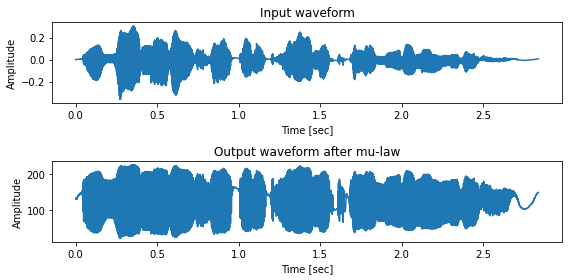

In [28]:
timeaxis = np.arange(len(x)) / sr

fig, ax = subplots(2,1, figsize=(8,4))
ax[0].set_title("Input waveform")
ax[1].set_title("Output waveform after mu-law")

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Amplitude")
ax[0].plot(timeaxis, x)
ax[1].plot(timeaxis, quantized_x)
plt.tight_layout()

#### レシピの stage 3 の実行

上記の処理を行うバッチ処理のプログラムは、`preprocess_wavenet.py` にあります。

In [29]:
if run_sh:
    ! ./run.sh --stage 3 --stop-stage 3 --n-jobs $n_jobs

### 特徴量の正規化

正規化のための統計量を計算するコマンドラインプログラムは、 `recipes/common/fit_scaler.py` を参照してください。また、正規化を行うコマンドラインプログラムは、 `recipes/common/preprocess_normalize.py` を参照してください。

#### レシピの stage 4 の実行

In [30]:
if run_sh:
    ! ./run.sh --stage 4 --stop-stage 4 --n-jobs $n_jobs

#### 正規化の処理の結果の確認

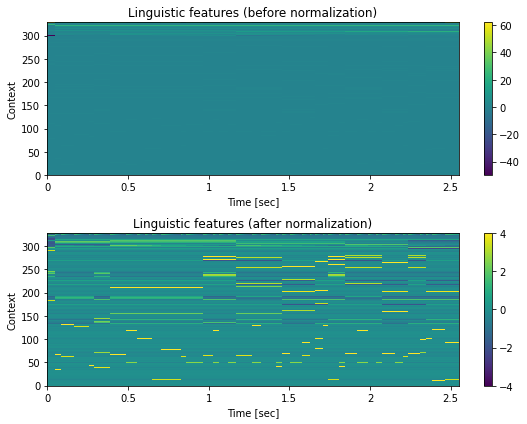

In [31]:
# 言語特徴量の正規化前後
in_feats = np.load(f"dump/jsut_sr16000/org/train/in_logf0/{train_utt}-feats.npy")
in_feats_norm = np.load(f"dump/jsut_sr16000/norm/train/in_logf0/{train_utt}-feats.npy")
fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].set_title("Linguistic features (before normalization)")
ax[1].set_title("Linguistic features (after normalization)")
hop_length = int(sr * 0.005)
mesh = librosa.display.specshow(
    in_feats.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="frames", ax=ax[0], cmap=cmap)
fig.colorbar(mesh, ax=ax[0])
mesh = librosa.display.specshow(
    in_feats_norm.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="frames",ax=ax[1], cmap=cmap)
# NOTE: 実際には [-4, 4]の範囲外の値もありますが、視認性のために [-4, 4]に設定します
mesh.set_clim(-4, 4)
fig.colorbar(mesh, ax=ax[1])

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Context")
    # 末尾の非音声区間を除く
    a.set_xlim(0, 2.55)
    
plt.tight_layout()

## 8.3 継続長モデルの学習

### 継続長モデルの設定ファイル

In [32]:
! cat conf/train_dnntts/model/{duration_config_name}.yaml

netG:
  _target_: ttslearn.dnntts.LSTMRNN
  in_dim: 325
  out_dim: 1
  hidden_dim: 64
  bidirectional: False
  num_layers: 2
  dropout: 0.5

stream_sizes: [1]
has_dynamic_features: [false]


### 継続長モデルのインスタンス化

In [33]:
import hydra
from omegaconf import OmegaConf
hydra.utils.instantiate(OmegaConf.load(f"conf/train_dnntts/model/{duration_config_name}.yaml").netG)

LSTMRNN(
  (lstm): LSTM(325, 64, num_layers=2, batch_first=True, dropout=0.5)
  (hidden2out): Linear(in_features=64, out_features=1, bias=True)
)

### レシピの stage 5 の実行

In [34]:
if run_sh:
    ! ./run.sh --stage 5 --stop-stage 5 --duration-model $duration_config_name \
        --tqdm $run_sh_tqdm --dnntts-data-batch-size $dnntts_batch_size --dnntts-train-nepochs $dnntts_nepochs \
        --cudnn-benchmark $cudnn_benchmark --cudnn-deterministic $cudnn_deterministic

### 損失関数の値の推移

著者による実験結果です。Tensorboardのログは https://tensorboard.dev/ にアップロードされています。
ログデータを`tensorboard` パッケージを利用してダウンロードします。

https://tensorboard.dev/experiment/yXyg9qgfQRSGxvil5FA4xw/

In [35]:
if exists("tensorboard/all_log.csv"):
    df = pd.read_csv("tensorboard/all_log.csv")
else:
    experiment_id = "yXyg9qgfQRSGxvil5FA4xw"
    experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
    df = experiment.get_scalars() 
    df.to_csv("tensorboard/all_log.csv", index=False)
df["run"].unique()

ValueError: Error [from server]: 
****************************************************************
****************************************************************
****************************************************************

ERROR: TensorBoard.dev has been shut down.

This command is no longer operational and will be removed.

See the FAQ at https://tensorboard.dev.

****************************************************************
****************************************************************
****************************************************************


In [ ]:
duration_loss = df[df.run.str.contains("duration")]

duration_train_loss = duration_loss[duration_loss.tag.str.contains("Loss/train")]
duration_dev_loss = duration_loss[duration_loss.tag.str.contains("Loss/dev")]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(duration_train_loss["step"], duration_train_loss["value"], label="Train")
ax.plot(duration_dev_loss["step"], duration_dev_loss["value"], "--", label="Dev")
ax.set_xlabel("Epoch")
ax.set_ylabel("Epoch loss")
plt.legend()

# 図8-3
savefig("fig/wavenet_impl_duration_loss")

## 8.4 対数 F0 予測モデルの学習

### 対数 F0 予測モデルの設定ファイル

In [ ]:
! cat conf/train_dnntts/model/{logf0_config_name}.yaml

netG:
  _target_: ttslearn.dnntts.LSTMRNN
  in_dim: 329
  out_dim: 4
  hidden_dim: 64
  bidirectional: True
  num_layers: 2
  dropout: 0.5

# (lf0, vuv)
stream_sizes: [3, 1]
has_dynamic_features: [true, false]
num_windows: 3


### 対数 F0 予測モデルのインスタンス化

In [ ]:
import hydra
from omegaconf import OmegaConf
hydra.utils.instantiate(OmegaConf.load(f"conf/train_dnntts/model/{logf0_config_name}.yaml").netG)

LSTMRNN(
  (lstm): LSTM(329, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (hidden2out): Linear(in_features=128, out_features=4, bias=True)
)

### レシピの stage 6 の実行

In [ ]:
if run_sh:
    ! ./run.sh --stage 6 --stop-stage 6 --logf0-model $logf0_config_name \
        --tqdm $run_sh_tqdm --dnntts-data-batch-size $dnntts_batch_size --dnntts-train-nepochs $dnntts_nepochs \
        --cudnn-benchmark $cudnn_benchmark --cudnn-deterministic $cudnn_deterministic

### 損失関数の値の推移

In [ ]:
logf0_loss = df[df.run.str.contains("logf0")]

logf0_train_loss = logf0_loss[logf0_loss.tag.str.contains("Loss/train")]
logf0_dev_loss = logf0_loss[logf0_loss.tag.str.contains("Loss/dev")]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(logf0_train_loss["step"], logf0_train_loss["value"], label="Train")
ax.plot(logf0_dev_loss["step"], logf0_dev_loss["value"], "--", label="Dev")
ax.set_xlabel("Epoch")
ax.set_ylabel("Epoch loss")
plt.legend()

# 図8-4
savefig("fig/wavenet_impl_logf0_loss")

## 8.5 WaveNet の学習スクリプトの実装

### DataLoaderの実装

#### collate_fn の実装

In [ ]:
def collate_fn_wavenet(batch, max_time_frames=100, hop_size=80, aux_context_window=2):
    max_time_steps = max_time_frames * hop_size

    xs, cs = [b[1] for b in batch], [b[0] for b in batch]

    # 条件付け特徴量の開始位置をランダム抽出した後、それに相当する短い音声波形を切り出します
    c_lengths = [len(c) for c in cs]
    start_frames = np.array(
        [
            np.random.randint(
                aux_context_window, cl - aux_context_window - max_time_frames
            )
            for cl in c_lengths
        ]
    )
    x_starts = start_frames * hop_size
    x_ends = x_starts + max_time_steps
    c_starts = start_frames - aux_context_window
    c_ends = start_frames + max_time_frames + aux_context_window
    x_batch = [x[s:e] for x, s, e in zip(xs, x_starts, x_ends)]
    c_batch = [c[s:e] for c, s, e in zip(cs, c_starts, c_ends)]

    # numpy.ndarray のリスト型から torch.Tensor 型に変換します
    x_batch = torch.tensor(x_batch, dtype=torch.long)  # (B, T)
    c_batch = torch.tensor(c_batch, dtype=torch.float).transpose(2, 1)  # (B, C, T')

    return x_batch, c_batch

#### DataLoader の利用例

`hop_size`を80に設定しているので、音声波形サイズは条件付け特徴量の80倍

In [ ]:
from pathlib import Path
from ttslearn.train_util import Dataset
from functools import partial

in_paths = sorted(Path("./dump/jsut_sr16000/norm/dev/in_wavenet/").glob("*.npy"))
out_paths = sorted(Path("./dump/jsut_sr16000/org/dev/out_wavenet/").glob("*.npy"))

dataset = Dataset(in_paths, out_paths)
collate_fn = partial(collate_fn_wavenet, max_time_frames=100, hop_size=80, aux_context_window=0)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, collate_fn=collate_fn, num_workers=0)

wavs, feats = next(iter(data_loader))

print("音声波形のサイズ:", tuple(wavs.shape))
print("条件付け特徴量のサイズ:", tuple(feats.shape))

音声波形のサイズ: (8, 8000)
条件付け特徴量のサイズ: (8, 333, 100)


/home/vscode/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/torch/csrc/utils/tensor_new.cpp:201.)


#### ミニバッチの可視化

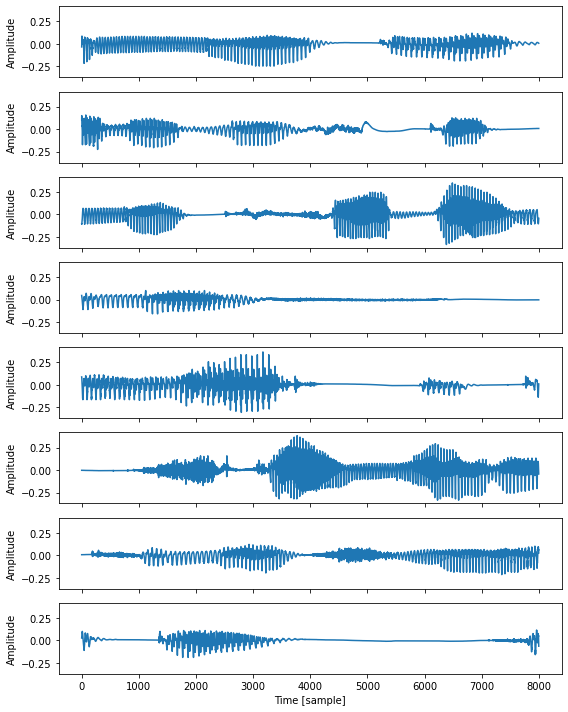

In [ ]:
from ttslearn.dsp import inv_mulaw_quantize

fig, ax = plt.subplots(len(wavs), 1, figsize=(8,10), sharex=True, sharey=True)
for n in range(len(wavs)):
    x = wavs[n].data.numpy()
    x = inv_mulaw_quantize(x, 255)
    ax[n].plot(x)

ax[-1].set_xlabel("Time [sample]")
for a in ax:
    a.set_ylabel("Amplitude")
plt.tight_layout()

# 図8-5
savefig("fig/wavenet_impl_minibatch")

### 簡易的な学習スクリプトの実装

#### モデルパラメータの指数移動平均

In [ ]:
def moving_average_(model, model_test, beta=0.9999):
    for param, param_test in zip(model.parameters(), model_test.parameters()):
        param_test.data = torch.lerp(param.data, param_test.data, beta)

#### 学習の前準備

In [ ]:
from ttslearn.wavenet import WaveNet
from torch import optim

# 動作確認用：層の数を減らした小さなWaveNet
ToyWaveNet = partial(WaveNet, out_channels=256, layers=2, stacks=1, kernel_size=2, cin_channels=333)

model = ToyWaveNet()
# モデルパラメータの指数移動平均
model_ema = ToyWaveNet()
model_ema.load_state_dict(model.state_dict())

# lr は学習率を表します
optimizer = optim.Adam(model.parameters(), lr=0.01)

# gamma は学習率の減衰係数を表します
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=100000)

#### 学習ループの実装

In [ ]:
# DataLoader を用いたミニバッチの作成: ミニバッチ毎に処理を行う
for x, c in data_loader:
    # 順伝播の計算
    x_hat = model(x, c)
    # 負の対数尤度の計算
    loss = nn.CrossEntropyLoss()(x_hat[:, :, :-1], x[:, 1:]).mean()
    # 損失の値を出力
    print(loss.item())
    # optimizer に蓄積された勾配をリセット
    optimizer.zero_grad()
    # 誤差の逆伝播の計算
    loss.backward()
    # パラメータの更新
    optimizer.step()
    # 移動指数平均の計算
    moving_average_(model, model_ema)
    # 学習率スケジューラの更新
    lr_scheduler.step()

5.511545658111572
5.406107425689697
5.346164703369141
5.2227678298950195
5.309933185577393
5.193245887756348
5.157327175140381
5.177829742431641
5.196837425231934
5.0825300216674805
5.143543720245361
5.0417399406433105
5.019702434539795
4.986400604248047
4.912967205047607
4.931775093078613
4.861066818237305
4.801878929138184
4.796083450317383
4.7324395179748535
4.725325107574463
4.634120941162109
4.723519325256348
4.536928176879883
4.5202484130859375


### 実用的な学習スクリプトの実装

`train_wavenet.py` を参照してください。

## 8.6 WaveNet の学習

### WaveNet の設定ファイル

In [ ]:
! cat conf/train_wavenet/model/{wavenet_config_name}.yaml

### WaveNet のインスタンス化

In [ ]:
import hydra
from omegaconf import OmegaConf
# WaveNet の 30層 すべてを表示すると長くなるため、ここでは省略します。
# hydra.utils.instantiate(OmegaConf.load(f"./conf/train_wavenet/model/{wavenet_config_name}.yaml")["netG"])

### レシピの stage 7 の実行

In [ ]:
if run_sh:
    ! ./run.sh --stage 7 --stop-stage 7 --wavenet-model $wavenet_config_name \
        --tqdm $run_sh_tqdm --wavenet-data-batch-size $wavenet_batch_size --wavenet-train-max-train-steps $wavenet_max_train_steps \
        --cudnn-benchmark $cudnn_benchmark --cudnn-deterministic $cudnn_deterministic

### 損失関数の値の推移

In [ ]:
wavenet_loss = df[df.run.str.contains("wavenet")]

wavenet_train_loss = wavenet_loss[wavenet_loss.tag.str.contains("Loss/train")]
wavenet_dev_loss = wavenet_loss[wavenet_loss.tag.str.contains("Loss/dev")]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(wavenet_train_loss["step"], wavenet_train_loss["value"], label="Train")
ax.plot(wavenet_dev_loss["step"], wavenet_dev_loss["value"], "--", label="Dev")
ax.set_xlabel("Epoch")
ax.set_ylabel("Epoch loss")
ax.set_ylim(1.7, 2.2)
plt.legend()

# 図8-6
savefig("fig/wavenet_impl_wavenet_loss")

## 8.7 学習済みモデルを用いてテキストから音声を合成

### 学習済みモデルの読み込み

In [36]:
import joblib
device = torch.device("cpu")

#### 継続長モデルの読み込み

In [37]:
duration_config = OmegaConf.load(f"exp/jsut_sr16000/{duration_config_name}/model.yaml")
duration_model = hydra.utils.instantiate(duration_config.netG)
checkpoint = torch.load(f"exp/jsut_sr16000/{duration_config_name}/latest.pth", map_location=device)
duration_model.load_state_dict(checkpoint["state_dict"])
duration_model.eval();

#### 対数F0予測モデルの読み込み

In [38]:
logf0_config = OmegaConf.load(f"exp/jsut_sr16000/{logf0_config_name}/model.yaml")
logf0_model = hydra.utils.instantiate(logf0_config.netG)
checkpoint = torch.load(f"exp/jsut_sr16000/{logf0_config_name}/latest.pth", map_location=device)
logf0_model.load_state_dict(checkpoint["state_dict"])
logf0_model.eval();

#### WaveNetの読み込み

In [39]:
wavenet_config = OmegaConf.load(f"exp/jsut_sr16000/{wavenet_config_name}/model.yaml")
wavenet_model = hydra.utils.instantiate(wavenet_config.netG)
checkpoint = torch.load(f"exp/jsut_sr16000/{wavenet_config_name}/latest_ema.pth", map_location=device)
wavenet_model.load_state_dict(checkpoint["state_dict"])
# weight normalization は推論時には不要なため除く
wavenet_model.remove_weight_norm_()
wavenet_model.eval();

#### 統計量の読み込み

In [40]:
duration_in_scaler = joblib.load("./dump/jsut_sr16000/norm/in_duration_scaler.joblib")
duration_out_scaler = joblib.load("./dump/jsut_sr16000/norm/out_duration_scaler.joblib")
logf0_in_scaler = joblib.load("./dump/jsut_sr16000/norm/in_logf0_scaler.joblib")
logf0_out_scaler = joblib.load("./dump/jsut_sr16000/norm/out_logf0_scaler.joblib")
wavenet_in_scaler = joblib.load("./dump/jsut_sr16000/norm/in_wavenet_scaler.joblib")

### 音素継続長の予測

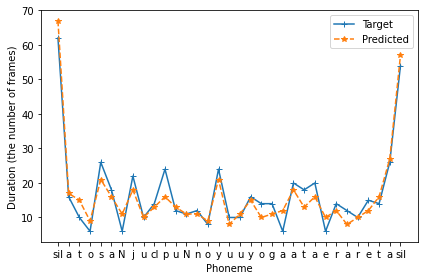

In [41]:
from ttslearn.util import lab2phonemes, find_lab, find_feats
from ttslearn.dnntts.gen import predict_duration

labels = hts.load(find_lab("downloads/jsut_ver1.1/", test_utt))

# フルコンテキストラベルから音素のみを抽出
test_phonemes = lab2phonemes(labels)

# 言語特徴量の抽出に使うための質問ファイル
binary_dict, numeric_dict = hts.load_question_set(ttslearn.util.example_qst_file())

# 音素継続長の予測
durations_test = predict_duration(
    device, labels, duration_model, duration_config, duration_in_scaler, duration_out_scaler,
    binary_dict, numeric_dict)
durations_test_target = np.load(find_feats("dump/jsut_sr16000/org", test_utt, typ="out_duration"))

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(durations_test_target, "-+", label="Target")
ax.plot(durations_test, "--*", label="Predicted")
ax.set_xticks(np.arange(len(test_phonemes)))
ax.set_xticklabels(test_phonemes)
ax.set_xlabel("Phoneme")
ax.set_ylabel("Duration (the number of frames)")
ax.legend()

plt.tight_layout()

### 対数基本周波数の予測

In [42]:
from ttslearn.dnntts.gen import predict_acoustic

labels = hts.load(find_lab("downloads/jsut_ver1.1/", test_utt))
# 対数基本周波数の予測
out_feats = predict_acoustic(
    device, labels, logf0_model, logf0_config, logf0_in_scaler,
    logf0_out_scaler, binary_dict, numeric_dict)

In [43]:
from ttslearn.util import trim_silence
from ttslearn.dnntts.multistream import split_streams

# 結合された特徴量を分離
out_feats = trim_silence(out_feats, labels)
lf0_gen, vuv_gen = out_feats[:, 0], out_feats[:, 1]

In [44]:
from ttslearn.dnntts.multistream import get_static_features

# 比較用に、自然音声から抽出された音響特徴量を読み込みむ
feats = np.load(find_feats("dump/jsut_sr16000/org/", test_utt, typ="out_logf0"))
# 特徴量の分離
lf0_ref, vuv_ref = get_static_features(
    feats, logf0_config.num_windows, logf0_config.stream_sizes, logf0_config.has_dynamic_features)

#### F0の可視化

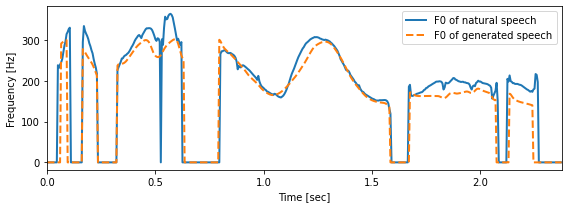

In [45]:
# 対数基本周波数から基本周波数への変換
f0_ref = np.exp(lf0_ref)
f0_ref[vuv_ref < 0.5] = 0
f0_gen = np.exp(lf0_gen)
f0_gen[vuv_gen < 0.5] = 0

timeaxis = librosa.frames_to_time(np.arange(len(f0_ref)), sr=sr, hop_length=int(0.005 * sr))

fix, ax = plt.subplots(1,1, figsize=(8,3))
ax.plot(timeaxis, f0_ref, linewidth=2, label="F0 of natural speech")
ax.plot(timeaxis, f0_gen, "--", linewidth=2, label="F0 of generated speech")

ax.set_xlabel("Time [sec]")
ax.set_ylabel("Frequency [Hz]")
ax.set_xlim(timeaxis[0], timeaxis[-1])

plt.legend()
plt.tight_layout()

### 音声波形の生成

In [46]:
from ttslearn.dsp import inv_mulaw_quantize

@torch.no_grad()
def gen_waveform(
    device,  # cpu or cuda
    labels,  # フルコンテキストラベル
    logf0_vuv,  # 連続対数基本周波数と有声/無声フラグ
    wavenet_model,  # 学習済み WaveNet
    wavenet_in_scaler,  # 条件付け特徴量の正規化用 StandardScaler
    binary_dict,  # 二値特徴量を抽出する正規表現
    numeric_dict,  # 数値特徴量を抽出する正規表現
    tqdm=tqdm,  # プログレスバー
):
    # フレーム単位の言語特徴量の抽出
    in_feats = fe.linguistic_features(
        labels,
        binary_dict,
        numeric_dict,
        add_frame_features=True,
        subphone_features="coarse_coding",
    )
    # フレーム単位の言語特徴量と、対数連続基本周波数・有声/無声フラグを結合
    in_feats = np.hstack([in_feats, logf0_vuv])

    # 特徴量の正規化
    in_feats = wavenet_in_scaler.transform(in_feats)

    # 条件付け特徴量を numpy.ndarray から torch.Tensor に変換
    c = torch.from_numpy(in_feats).float().to(device)
    # (B, T, C) -> (B, C, T)
    c = c.view(1, -1, c.size(-1)).transpose(1, 2)

    # 音声波形の長さを計算
    upsample_scale = np.prod(wavenet_model.upsample_scales)
    time_steps = (c.shape[-1] - wavenet_model.aux_context_window * 2) * upsample_scale

    # WaveNet による音声波形の生成
    # NOTE: 計算に時間を要するため、tqdm によるプログレスバーを利用します
    gen_wav = wavenet_model.inference(c, time_steps, tqdm)

    # One-hot ベクトルから 1 次元の信号に変換
    gen_wav = gen_wav.max(1)[1].float().cpu().numpy().reshape(-1)

    # Mu-law 量子化の逆変換
    gen_wav = inv_mulaw_quantize(gen_wav, wavenet_model.out_channels - 1)

    return gen_wav

### すべてのモデルを組み合わせて音声波形の生成

In [47]:
# NOTE: False の場合、正解のdurationsを使います
# すべてのモデルを連結する場合、True にしてください
use_ground_truth_durations = True

labels = hts.load(find_lab("downloads/jsut_ver1.1/", test_utt))

# 言語特徴量の抽出の下準備
binary_dict, numeric_dict = hts.load_question_set(ttslearn.util.example_qst_file())

if not use_ground_truth_durations:
    # 音素継続長の予測
    durations = predict_duration(
        device, labels, duration_model, duration_config, duration_in_scaler, duration_out_scaler,
        binary_dict, numeric_dict)

    # 予測された継続長をフルコンテキストラベルに設定
    labels.set_durations(durations)

# 対数基本周波数の予測
# NOTE: 動的特徴量をWaveNetの条件付け特徴量に用いるため、パラメータ生成 (mlpg) は行わない
logf0_vuv = predict_acoustic(
    device, labels, logf0_model, logf0_config, logf0_in_scaler,
    logf0_out_scaler, binary_dict, numeric_dict, mlpg=False)

# WaveNetによる音声波形の生成
gen_wav = gen_waveform(
    device, labels, logf0_vuv, wavenet_model, wavenet_in_scaler,
    binary_dict, numeric_dict, tqdm)

  0%|          | 0/44640 [00:00<?, ?it/s]

In [48]:
# 比較用に元音声の読み込み
from scipy.io import wavfile
_sr, ref_wav = wavfile.read(f"./downloads/jsut_ver1.1/basic5000/wav/{test_utt}.wav")
ref_wav = (ref_wav / 32768.0).astype(np.float64)
ref_wav = librosa.resample(ref_wav,orig_sr= _sr,target_sr= sr)

自然音声


WaveNet音声合成


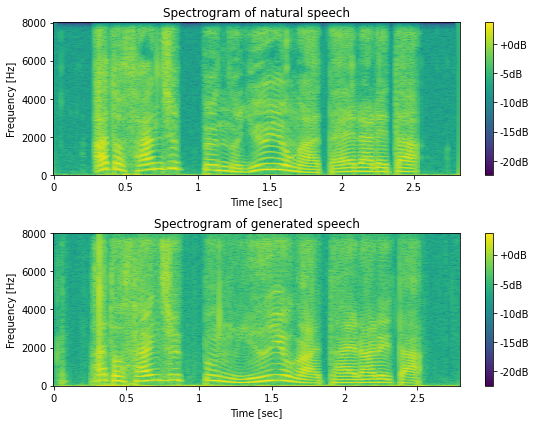

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))

hop_length = int(sr * 0.005)
fft_size = pyworld.get_cheaptrick_fft_size(sr)

spec_ref = librosa.stft(ref_wav, n_fft=fft_size, hop_length=hop_length, window="hann")
logspec_ref = np.log(np.abs(spec_ref))
spec_gen = librosa.stft(gen_wav, n_fft=fft_size, hop_length=hop_length, window="hann")
logspec_gen = np.log(np.abs(spec_gen))

mindb = min(logspec_ref.min(), logspec_gen.min())
maxdb = max(logspec_ref.max(), logspec_gen.max())

mesh = librosa.display.specshow(logspec_ref, hop_length=hop_length, sr=sr, cmap=cmap, x_axis="time", y_axis="hz", ax=ax[0])
mesh.set_clim(mindb, maxdb)
fig.colorbar(mesh, ax=ax[0], format="%+2.fdB")

mesh = librosa.display.specshow(logspec_gen, hop_length=hop_length, sr=sr, cmap=cmap, x_axis="time", y_axis="hz", ax=ax[1])
mesh.set_clim(mindb, maxdb)
fig.colorbar(mesh, ax=ax[1], format="%+2.fdB")

ax[0].set_title("Spectrogram of natural speech")
ax[1].set_title("Spectrogram of generated speech")
for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Frequency [Hz]")

plt.tight_layout()

print("自然音声")
IPython.display.display(Audio(ref_wav, rate=sr))
print("WaveNet音声合成")
IPython.display.display(Audio(gen_wav, rate=sr))

# 図8-7
savefig("./fig/wavenet_impl_tts_spec_comp")

半分くらいで打ち切ってこれならすごい気がする

### 評価データに対して音声波形生成

#### レシピの stage 8 の実行

In [ ]:
if run_sh and run_stage8:
    ! ./run.sh --stage 8 --stop-stage 8 \
        --tqdm $run_sh_tqdm --duration-model $duration_config_name --logf0-model $logf0_config_name --wavenet-model $wavenet_config_name \
        --reverse true --num-eval-utts $num_eval_utts

## 自然音声と合成音声の比較 (bonus)

In [51]:
from pathlib import Path
from ttslearn.util import load_utt_list

with open("./downloads/jsut_ver1.1/basic5000/transcript_utf8.txt") as f:
    transcripts = {}
    for l in f:
        utt_id, script = l.split(":")
        transcripts[utt_id] = script
        
eval_list = load_utt_list("data/eval.list")[::-1][:5]

for utt_id in eval_list:
    # ref file 
    ref_file = f"./downloads/jsut_ver1.1/basic5000/wav/{utt_id}.wav"
    _sr, ref_wav = wavfile.read(ref_file)
    ref_wav = (ref_wav / 32768.0).astype(np.float64)
    ref_wav = librosa.resample(ref_wav, orig_sr=_sr,target_sr= sr)
    
    print(f"{utt_id}: {transcripts[utt_id]}")
    print("自然音声")
    IPython.display.display(Audio(ref_wav, rate=sr))

    gen_file = f"exp/jsut_sr16000/synthesis_{duration_config_name}_{logf0_config_name}_{wavenet_config_name}/eval/{utt_id}.wav"
    if exists(gen_file):
        _sr, gen_wav = wavfile.read(gen_file)    
        print("WaveNet音声合成")
        IPython.display.display(Audio(gen_wav, rate=sr))
    else:
        # 音声生成が完了していない場合
        print("WaveNet音声合成: not found")

BASIC5000_5000: あと３０分の猶予が与えられた。

自然音声


WaveNet音声合成: not found
BASIC5000_4999: ドナーから腎臓の提供を受ける。

自然音声


WaveNet音声合成: not found
BASIC5000_4998: 村人たちは、その話を聞いて、震え上がった。

自然音声


WaveNet音声合成: not found
BASIC5000_4997: その王国は、最後の王に嗣子がおらず、滅亡した。

自然音声


WaveNet音声合成: not found
BASIC5000_4996: 扇型の、弧の長さを、計算で求める。

自然音声


WaveNet音声合成: not found


## 学習済みモデルのパッケージング (bonus)

学習済みモデルを利用したTTSに必要なファイルをすべて単一のディレクトリにまとめます。
`ttslearn.wavenet.WaveNetTTS` クラスには、まとめたディレクトリを指定し、TTSを行う機能が実装されています。

### レシピの stage 99 の実行

In [ ]:
if run_sh:
    ! ./run.sh --stage 99 --stop-stage 99 \
        --duration-model $duration_config_name --logf0-model $logf0_config_name --wavenet-model $wavenet_config_name

In [ ]:
!ls tts_models/jsut_sr16000_{duration_config_name}_{logf0_config_name}_{wavenet_config_name}

### パッケージングしたモデルを利用したTTS

In [ ]:
from ttslearn.wavenet import WaveNetTTS

# パッケージングしたモデルのパスを指定します
engine = WaveNetTTS(
    model_dir=f"./tts_models/jsut_sr16000_{duration_config_name}_{logf0_config_name}_{wavenet_config_name}"
)
wav, sr = engine.tts("ここまでお読みいただき、ありがとうございました。", tqdm=tqdm)

fig, ax = plt.subplots(figsize=(8,2))
librosa.display.waveshow(wav.astype(np.float32), sr, ax=ax)
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Amplitude")
plt.tight_layout()

Audio(wav, rate=sr)

In [ ]:
if is_colab():
    from datetime import timedelta
    elapsed = (time.time() - start_time)
    print("所要時間:", str(timedelta(seconds=elapsed)))